## Reproduction of Table: person using Python

* Found a way to apply multiple functions to multiple groupby columns
* Python can be as efficient and elegant in creating this table as SQL
* Additional visualization on top 3 freelancers' monthly income by project <br><br>

* These data can provides insights on <b>freelancers' working behavior</b>, e.g. how frequent they work, but
* Give no clues about <b>freelancer's data entry behavior</b>, e.g. when and how frequent they enter their time <br><br>

* Time spent on table reproduction: 2 hours 20 minutes (yeah!)
* Duration for table reproduction: 2018/05/02 to 2018/05/02

In [182]:
#Data: what is the data to be included in the table?
#Source: where is the data being collected from?
#Formula: how is the data being processed?

In [183]:
%%html
<style>
table { float: left }
</style>

| data | source | formula | remarks |
| ----------------- | ------------------------- | ------- | - |
| person_id         | timesheet.person_id       | groupby |   |
| person_name       | timesheet.person_name     | groupby |   |
| entry_count       | timesheet.duration        | count   |   |
| total_entry_hours | timesheet.duration        | sum     |   |
| avg_entry_hours   | timesheet.duration        | mean    | sum/count |
| min_entry_hours   | timesheet.duration        | min     |   |
| max_entry_hours   | timesheet.duration        | max     |   |
| first_entry       | timesheet.start_datetime  | min     |   |
| latest_entry      | timesheet.stop_datetime   | max     |   |
| activity_days     | timesheet.datetime        | minus   | stop - start |
| total_gross       | timesheet.total           | sum     |   |
| total_discount    | timesheet.total_discount  | sum     |   |
| project_count     | timesheet.account_name    | count   |   |

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import datetime
import time
import pytz
import dateutil
from dateutil import relativedelta

sns.set(color_codes=True)

In [165]:
# Database connection credentials

user = "postgres"
password = "200323201"
host = "localhost"
port = "5432"
database = "heroku-timesheet"

In [166]:
db_string = "postgresql://{user}:{password}@{host}:{port}/{database}".format(user=user, 
                                                                             password=password,
                                                                             host=host,
                                                                             port=port,
                                                                             database=database)

In [167]:
from sqlalchemy import create_engine
engine = create_engine(db_string)
con = engine.connect()

In [168]:
query = """
    SELECT model.timesheet.person_id,
           model.timesheet.person_name,
           model.timesheet.duration,
           model.timesheet.start_datetime,
           model.timesheet.stop_datetime,
           model.timesheet.total,
           model.timesheet.total_discount,
           model.timesheet.account_name
    FROM model.timesheet
        """

In [169]:
timesheet = pd.read_sql(query, con)

In [170]:
timesheet.head()

,person_id,person_name,duration,start_datetime,stop_datetime,total,total_discount,account_name
0,fbd4990b-7e22-45b1-b6db-27d13294e39c,Théophile Sandoz,11:00:00,2017-09-20 01:00:00+00:00,2017-09-20 12:00:00+00:00,3300.0,0.0,AKQA
1,fbd4990b-7e22-45b1-b6db-27d13294e39c,Théophile Sandoz,11:00:00,2017-09-21 01:00:00+00:00,2017-09-21 12:00:00+00:00,3300.0,0.0,AKQA
2,fbd4990b-7e22-45b1-b6db-27d13294e39c,Théophile Sandoz,11:00:00,2017-09-22 01:00:00+00:00,2017-09-22 12:00:00+00:00,3300.0,0.0,AKQA
3,fbd4990b-7e22-45b1-b6db-27d13294e39c,Théophile Sandoz,11:00:00,2017-09-25 01:00:00+00:00,2017-09-25 12:00:00+00:00,3300.0,0.0,AKQA
4,fbd4990b-7e22-45b1-b6db-27d13294e39c,Théophile Sandoz,11:00:00,2017-09-26 01:00:00+00:00,2017-09-26 12:00:00+00:00,3300.0,0.0,AKQA


In [171]:
timesheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4093 entries, 0 to 4092
Data columns (total 8 columns):
person_id         4093 non-null object
person_name       4093 non-null object
duration          4093 non-null timedelta64[ns]
start_datetime    4093 non-null datetime64[ns, UTC]
stop_datetime     4093 non-null datetime64[ns, UTC]
total             4093 non-null float64
total_discount    4093 non-null float64
account_name      4093 non-null object
dtypes: datetime64[ns, UTC](2), float64(2), object(3), timedelta64[ns](1)
memory usage: 255.9+ KB


## Reproduction of Table: person

In [172]:
def person(timesheet):
    person = {}
    person['entry_count']       = timesheet['duration'].count()
    person['total_entry_hours'] = round(timesheet['duration'].sum().total_seconds()/3600, 2)
    person['avg_entry_hours']   = round(timesheet['duration'].sum().total_seconds()/3600/timesheet['duration'].count(), 2)
    person['min_entry_hours']   = round(timesheet['duration'].min().total_seconds()/3600, 2)
    person['max_entry_hours']   = round(timesheet['duration'].max().total_seconds()/3600, 2)
    person['first_entry']       = timesheet['start_datetime'].min().strftime('%Y/%m/%d')
    person['latest_entry']        = timesheet['stop_datetime'].max().strftime('%Y/%m/%d')
    person['activity_days']     = int(math.ceil((timesheet['stop_datetime'].max() - timesheet['start_datetime'].min()).total_seconds()/3600/24))
    person['total_gross']       = round(timesheet['total'].sum(), 2)
    person['total_discount']    = round(timesheet['total_discount'].sum(), 2)
    person['project_count']     = timesheet['account_name'].nunique()
    return pd.Series(person, index=['entry_count', 'total_entry_hours', 'avg_entry_hours', 'min_entry_hours', 'max_entry_hours',
                                    'first_entry', 'latest_entry', 'activity_days', 'total_gross', 'total_discount', 'project_count'])

person = timesheet.groupby(['person_name']).apply(person).sort_values(by=['total_gross'], ascending=False).reset_index()
person.head()

,person_name,entry_count,total_entry_hours,avg_entry_hours,min_entry_hours,max_entry_hours,first_entry,latest_entry,activity_days,total_gross,total_discount,project_count
0,Ricky Ng-Adam,574,780.75,1.36,0.25,7.00,2016/10/17,2018/04/15,546,396141.67,148458.33,16
1,Joe Beltrami,546,938.50,1.72,0.05,8.50,2016/12/07,2018/04/15,495,228546.67,0.00,3
2,Alex Miller,263,826.25,3.14,0.33,8.00,2017/08/24,2018/04/13,233,202187.50,2625.00,5
3,Abhishek Kumar,67,243.50,3.63,0.50,10.50,2017/10/23,2018/04/04,164,170450.00,0.00,4
4,Théophile Sandoz,50,464.38,9.29,4.00,12.25,2017/07/17,2017/09/29,75,139315.00,0.00,1


## Person_Project_View

In [173]:
print(timesheet['person_name'].unique(), 'Count:', timesheet['person_name'].nunique())

['Théophile Sandoz' 'Ricky Ng-Adam' 'Yangyang Xu' 'Joe Beltrami'
 'Frederic Bazin' 'Julie Li' 'Echo Ding' 'Gaurav Pahwa' 'Chun Zhang'
 'Alex Miller' 'Ruud Peters' 'David Yu' 'Rick Valenzuela'
 'Lukas Helebrandt' 'Nelson Zhang' 'Miguel Fernandez' 'Charles Umemoto'
 'Ilya Mochalov' 'Natalie Zimyatova' 'Stéphane Vernède' 'Karl Xu'
 'Shuyu Wu' 'Owen Zheng' 'Alberto Galán' 'Caroline Bon' 'Joseph Tsindos'
 'Thimo Visser' 'James Huajun Li' 'Abhishek Kumar' 'Gregory Orton'
 'Dmitry Kazakov' 'Gunnar Wagner' 'Eva Chen' 'Chan Ka Lung'
 'Mohammed BEN-THAIER' 'Eduardo Alarcon' 'Zhang Xiaochen' 'Todd Tang'
 'Christine Liu' 'Minyang Wang' 'Dora ZHANG' 'Douglas Wright'
 'Julien Choulet' 'Ross Cournoyer' 'John Madeley Evers' 'Margot Brulard'
 'Jesse Xu' 'Muhammad Hassan Qureshi' 'Qiong Zhang' 'Pony Ma'
 'Victor Robaglia' 'Yen Ting Wang' 'Terry Chen' 'Sugandha Pathak'] Count: 54


In [174]:
view = timesheet.copy()
view['time'] = view['start_datetime'].apply(lambda x: x.strftime('%Y-%m'))

In [175]:
#how much time each freelancer spend in each project monthly?
#groupby cannot provide margins, i.e. total of each row and column

view_duration = view.groupby(['person_name', 'account_name', 'time'])['duration'].apply(lambda x: round(x.sum().total_seconds()/3600, 2))
view_duration = view_duration.unstack().fillna(0)

In [176]:
#how much money each freelancer earn in each project monthly?
#pivot table can provide margins, i.e. total of each row and column
#some have wrong total due to wrong calculation of discount

view_total = view.pivot_table(index = ['person_name', 'account_name'], columns = 'time', values = 'total', aggfunc = np.sum, fill_value = 0, margins = True).apply(lambda x: round(x, 2))

In [196]:
#generate table for each freelancer

def individual_view_table(name, view):
    individual_view = view.loc[name].reset_index()
    return individual_view

In [197]:
view_duration_Ricky = individual_view_table('Ricky Ng-Adam', view_duration)
view_duration_Joe   = individual_view_table('Joe Beltrami', view_duration)
view_duration_Alex  = individual_view_table('Alex Miller', view_duration)
view_duration_Oscar = individual_view_table('Chan Ka Lung', view_duration)

In [198]:
view_total_Ricky    = individual_view_table('Ricky Ng-Adam', view_total)
view_total_Joe      = individual_view_table('Joe Beltrami', view_total)
view_total_Alex     = individual_view_table('Alex Miller', view_total)
view_total_Oscar    = individual_view_table('Chan Ka Lung', view_total)

In [215]:
#generate plot for each freelancer

def individual_view_plot(name, view):
    table = individual_view_table(name, view)
    x = table.columns.values[1:-1].tolist()
    y = table.values[:,1:-1].tolist()
    labels = table['account_name']
    plt.figure(figsize=(16,16))
    ax1 = plt.subplot(311)
    plt.stackplot(x, y, labels = labels)
    plt.legend(loc=2)
    plt.ylabel('Income')
    plt.xlabel('Month')
    plt.title('Monthly Income by project_' + name)
    return plt.show()

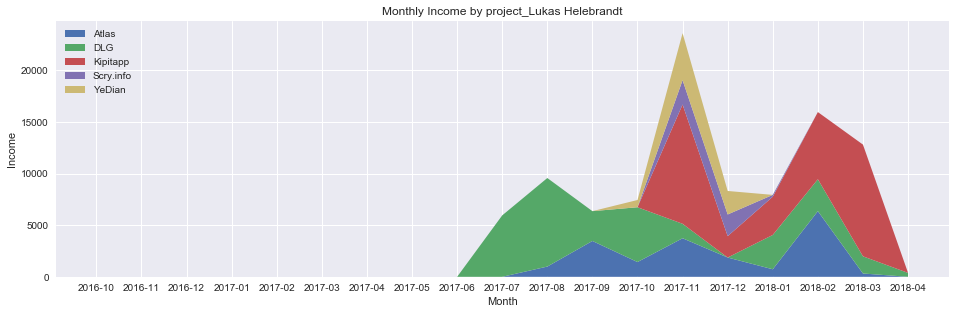

In [216]:
individual_view_plot('Lukas Helebrandt', view_total)

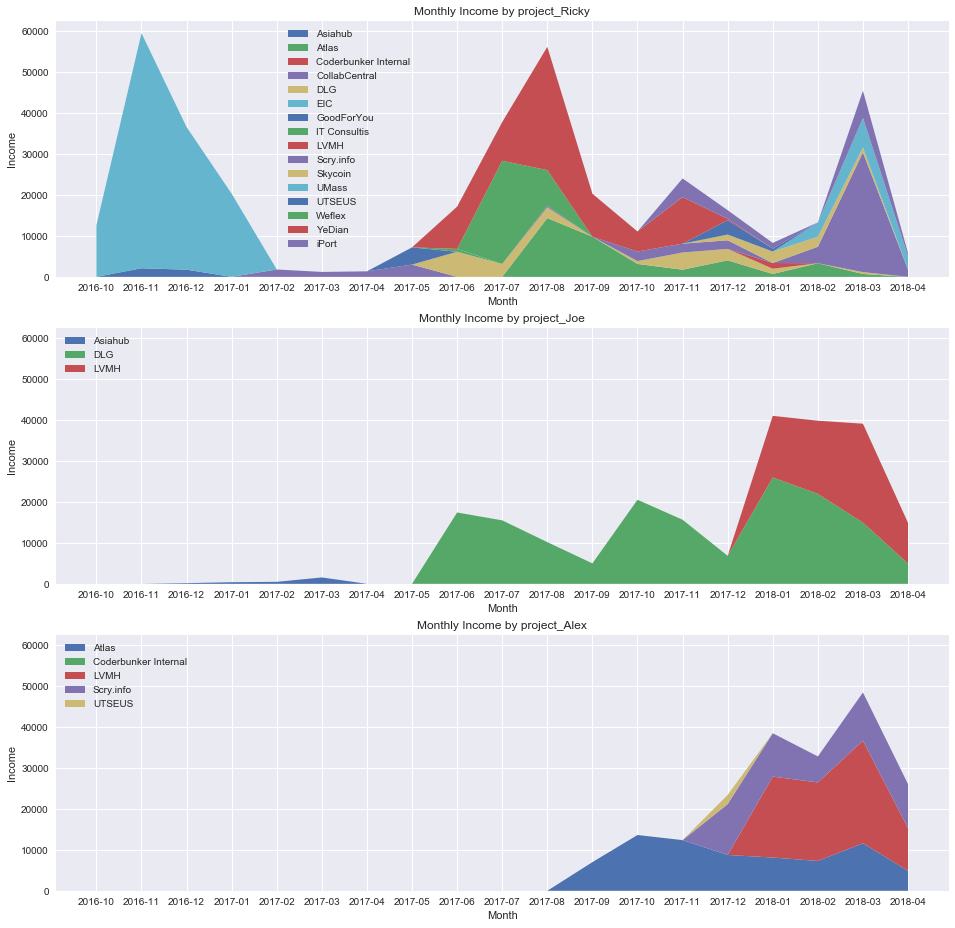

In [217]:
Ricky_x = view_total_Ricky.columns.values[1:-1].tolist()
Ricky_y = view_total_Ricky.values[:,1:-1].tolist()
Ricky_labels = view_total_Ricky['account_name']

Joe_x = view_total_Joe.columns.values[1:-1].tolist()
Joe_y = view_total_Joe.values[:,1:-1].tolist()
Joe_labels = view_total_Joe['account_name']

Alex_x = view_total_Alex.columns.values[1:-1].tolist()
Alex_y = view_total_Alex.values[:,1:-1].tolist()
Alex_labels = view_total_Alex['account_name']

Oscar_x = view_total_Oscar.columns.values[1:-1].tolist()
Oscar_y = view_total_Oscar.values[:,1:-1].tolist()
Oscar_labels = view_total_Oscar['account_name']

plt.figure(figsize=(16,16))

ax1 = plt.subplot(311)
plt.stackplot(Ricky_x, Ricky_y, labels = Ricky_labels)
plt.legend(loc=2, bbox_to_anchor=(0.25, 1))
plt.ylabel('Income')
plt.xlabel('Month')
plt.title('Monthly Income by project_Ricky')

ax2 = plt.subplot(312, sharey = ax1)
plt.stackplot(Joe_x, Joe_y, labels = Joe_labels)
plt.legend(loc=2)
plt.ylabel('Income')
plt.xlabel('Month')
plt.title('Monthly Income by project_Joe')

ax3 = plt.subplot(313, sharey = ax1)
plt.stackplot(Alex_x, Alex_y, labels = Alex_labels)
plt.legend(loc=2)
plt.ylabel('Income')
plt.xlabel('Month')
plt.title('Monthly Income by project_Alex')

plt.show()

#unique legend colors: https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib

## Freelancer Analysis

* Date entry behavior: how do freelancer enter their hours? / no data
* Working behavior: how do freelancer work? / yes
  * Average monthly income / person / monthly income
  * Billed members trend / time / count
  * Monthly income trend / time / count

In [181]:
person_entry = person[person['activity_days'] > 100].sort_values(by=['activity_days'], ascending=False)